In [6]:
from langgraph.graph import StateGraph,START, END
from langchain_core.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI 
from dotenv import load_dotenv
from typing import TypedDict
from pydantic import BaseModel , Field
# from langchain_core.schema import structured_output_parser

In [3]:
load_dotenv()
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature = 0.7)

In [7]:
class EvaluationSchema(BaseModel):
    feedback : str = Field(description="detailed feedback on the essay")
    score : int = Field(description="final Score out of 10",ge=0,le=10)
model = llm.with_structured_output(EvaluationSchema)


In [8]:
essay = """
In today's fast-paced world, technology has become an integral part of our daily lives.
From communication to transportation, technology has revolutionized the way we live and work. 
The advancements in technology have not only made our lives easier but have also opened up
new opportunities for innovation and growth. 
However, it is important to strike a balance between embracing technology and maintaining human connections.
As we continue to advance technologically, we must also ensure that we do not 
lose sight of the importance of empathy, compassion, and social interaction in our lives.
"""

In [10]:
prompt = PromptTemplate(
    input_variables = ["essay"],
    template = "Evaluate the following essay and provide detailed feedback and a score out of 10:\n\n{essay}"
)

response = model.invoke(prompt.format(essay=essay))
print("Final Score:", response.score)
print("Feedback:", response.feedback)

Final Score: 7
Feedback: The essay effectively introduces the pervasive nature of technology in modern life, highlighting its transformative impact on communication and transportation. It successfully argues for the benefits of technological advancements, such as making lives easier and opening new opportunities for innovation. Crucially, the essay also addresses the important counterpoint of maintaining human connections, empathy, compassion, and social interaction amidst technological progress. This shows a balanced perspective.

To enhance the essay, consider providing more specific examples or scenarios to illustrate the points made. For instance, how exactly has technology revolutionized communication, and what are specific instances where human connection might be at risk? Expanding on the "how" of striking a balance or the "impact" of losing human connection would add greater depth and persuasiveness. Additionally, a more developed introduction and conclusion could provide a str

In [11]:
class EvaluateEssay(TypedDict):
    essay : str
    Final_score : int
    Final_feedback : str

    COT_score : int
    DOA_score : int
    Language_score : int    

In [26]:
def evaluate_thought(state : EvaluateEssay) :
    essay = state["essay"]
    prompt = PromptTemplate(
        input_variables = ["essay"],
        template = """Evaluate the following essay based on the clarity of thought and provide scores out 
        of 10. 
        Instructions : 
        -Do not generate anything other than the score.
        -Provide only integer score between 0 to 10.
        -do not provide any explanation.
        Essay: {essay}"""
    )
    output = llm.invoke(prompt.format(essay=essay))
    return {"COT_score": output}

def evaluate_analysis(state: EvaluateEssay):
    essay = state["essay"]
    prompt = PromptTemplate(
        input_variables = ["essay"],
        template = """Evaluate the following essay based on the depth of analysis and provide scores out
        of 10.
        Instructions : 
        -Do not generate anything other than the score.
        -Provide only integer score between 0 to 10.
        -do not provide any explanation.
        Essay:{essay}"""
    )
    output = llm.invoke(prompt.format(essay=essay))
    return {"DOA_score": output}

def evaluate_language(state: EvaluateEssay):
    essay = state["essay"]
    prompt = PromptTemplate(
        input_variables = ["essay"],
        template = """Evaluate the following essay based on the language proficiency and provide scores out
        of 10. 
        Instructions : 
        -Do not generate anything other than the score.
        -Provide only integer score between 0 to 10.
        -do not provide any explanation.
        Essay:{essay}"""
    )
    output = llm.invoke(prompt.format(essay=essay))
    return {"Language_score": output}

def finalize_evaluation(state: EvaluateEssay):
    essay = state["essay"]
    cot_score = state["COT_score"]
    doa_score = state["DOA_score"]
    language_score = state["Language_score"]
    # final_score = (cot_score + doa_score + language_score) // 3
    prompt = PromptTemplate(
        input_variables = ["essay" , "COT_score" , "DOA_score" , "Language_score"],
        template = """Provide detailed feedback on the following essay on the basis of given criteria
        and provide score out of 10 .
        Criteria : 
        Clarity of Thought Score: {COT_score}
        Depth of Analysis Score: {DOA_score}
        Language Proficiency Score: {Language_score}

        Essay: {essay}"""
    )
    answer = model.invoke(prompt.format(essay=essay , COT_score=cot_score , DOA_score=doa_score , Language_score=language_score))
    return {
        "Final_score": answer.score,
        "Final_feedback": answer.feedback
    }


In [27]:
graph = StateGraph(EvaluateEssay)
graph.add_node("evaluate_clarity-of-thought", evaluate_thought)
graph.add_node("evaluate_depth-of-analysis", evaluate_analysis)
graph.add_node("evaluate_language-proficiency", evaluate_language)
graph.add_node("finalize_evaluation", finalize_evaluation)

graph.add_edge(START, "evaluate_clarity-of-thought")
graph.add_edge(START, "evaluate_depth-of-analysis")
graph.add_edge(START, "evaluate_language-proficiency")

graph.add_edge("evaluate_clarity-of-thought", "finalize_evaluation")
graph.add_edge("evaluate_depth-of-analysis", "finalize_evaluation")
graph.add_edge("evaluate_language-proficiency", "finalize_evaluation")

graph.add_edge("finalize_evaluation", END)

workflow = graph.compile()

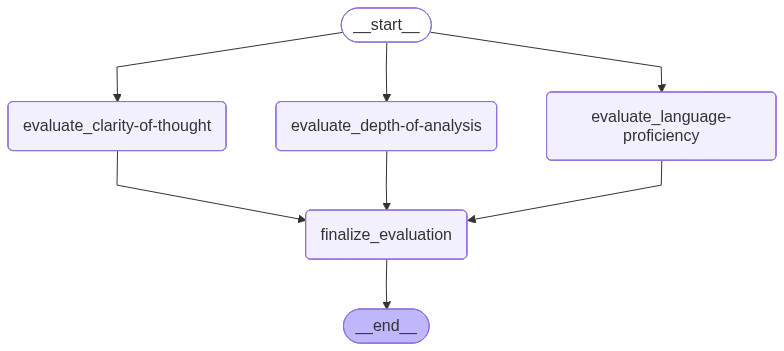

In [24]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [28]:
initial_state = {"essay" : essay}
final_state = workflow.invoke(initial_state)

In [29]:
print("Final Score:", final_state["Final_score"])

Final Score: 5


In [32]:
print("Cot score:", final_state["COT_score"].content)
print("DOA score:", final_state["DOA_score"].content)
print("Language score:", final_state["Language_score"].content)

Cot score: 9
DOA score: 1
Language score: 10


In [33]:
print("Final_feedback :" , final_state["Final_feedback"])

Final_feedback : 
**Detailed Feedback:**

**Clarity of Thought (Score: 9/10):**
The essay demonstrates excellent clarity of thought. The ideas are presented in a straightforward and easy-to-understand manner. The progression from the ubiquity of technology to the importance of human connection is logical and coherent. The main argument, though brief, is clear and unambiguous.

**Depth of Analysis (Score: 1/10):**
This is the weakest aspect of the essay. While the essay touches upon relevant points regarding technology's impact and the need for balance, it lacks any substantial depth of analysis. The statements are very general and do not delve into specific examples, elaborations, or nuanced arguments. For instance, it states technology has "revolutionized the way we live and work" and "opened up new opportunities," but it doesn't provide any concrete examples or explain *how* this revolution or these opportunities manifest. Similarly, the importance of "empathy, compassion, and social